<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

## Introduction


This Jupyter notebook includes examples on:
- Access [Gap-filled Fractional Snow Cover (GFSC)](https://land.copernicus.eu/en/products/snow/high-resolution-gap-filled-fractional-snow-cover) products through the HDA API
- Read and visualize GFSC products
- Manipulate the QCFLAGS layer to filter data according to sensor type
- Manipulate the AT layer to filter data according to data age

<hr>

## CLMS HRSI GFSC Product


The daily cumulative GFSC product is generated in near real-time (NRT) for the entire EEA38+UK domain.  It is based on SAR data from the Sentinel-1 (S1) constellation and  
optical data from the Sentinel-2 (S2) constellation. This product merges the latest observations to provide a spatially complete overview of snow conditions.

The GFSC product offers the extent of snow cover per pixel as a percentage (0% – 100%) with a spatial resolution of 60m x 60m. It utilizes [Fractional Snow Cover (FSC)](https://land.copernicus.eu/en/products/snow/fractional-snow-cover), [Wet/Dry Snow (WDS)](https://land.copernicus.eu/en/products/snow/high-resolution-wet-dry-snow), and [SAR Wet Snow  
(SWS)](https://land.copernicus.eu/en/products/snow/high-resolution-sar-wet-snow) products as inputs to create a comprehensive composite of snow conditions, reducing observational gaps caused by clouds and limited sensor coverage on a daily basis. The product applies the on-ground  
FSC and SWS data and presents the combined information as FSC.

### Environment Setup
Before we begin, we need to prepare our environment by installing and importing the necessary Python libraries:

In [2]:
#Uncomment and run if necessary
!pip install hda xmltodict --upgrade 'numpy<2.0'

  Using cached hda-2.22-py3-none-any.whl
  Using cached xmltodict-0.14.2-py2.py3-none-any.whl.metadata (8.0 kB)
Using cached xmltodict-0.14.2-py2.py3-none-any.whl (10.0 kB)
  Attempting uninstall: hda
    Found existing installation: hda 2.21
    Uninstalling hda-2.21:
      Successfully uninstalled hda-2.21


In [3]:
#Load required libraries
import os, sys, json, datetime, dateutil, shutil, tempfile, zipfile
import numpy as np
import matplotlib.pyplot as plt
import xmltodict
from osgeo import gdal
from matplotlib.colors import ListedColormap
from copy import deepcopy
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
from hda import Client

### WEkEO Account Registration

If you don't have a WEkEO account, please self-register at the <a href='https://my.wekeo.eu/web/guest/user-registration' target='_blank'>WEkEO registration page</a>.

### API Authentication

In order to interact with WEkEO's Harmonised Data Access API, each user shall ensure that the file '.hdarc' with username and password exists in the home directory. Please, find the tutorial on "how to" <a href='https://help.wekeo.eu/en/articles/6751608-how-to-use-the-hda-api-in-python' target='_blank'>here</a>. 

<hr>

## Process data with HDA Client

### Search Products

To search datasets, you need to construct a JSON query. You can create this query JSON manually or copy it from a manual search in the WEkEO Data Explorer.
<div>
<figure><img src='../../media/snow_and_ice/snow_and_ice_apicall.png' height='500px' />
    <figcaption><i>S2 Tile T32VMN</i></figcaption>
</figure>
</div>

In [4]:
query = {
  "dataset_id": "EO:CRYO:DAT:HRSI:GFSC",
  "bbox": [
    4.0488399662761605,
    60.64709920038568,
    9.213189474039462,
    61.81526952644772
  ],
  "startdate": "2022-03-13T00:00:00.000Z",
  "enddate": "2022-03-13T00:00:00.000Z",
  "cloudCover": "30"
}

For our working example, we will create a query that specifies a single day and tile. In this case, we will use tile T32TVM in the Scandinavian mountains on March 13, 2022:

<figure><img src='../../media/snow_and_ice/T32VMN.png' width='400px' />
    <figcaption><i>S2 Tile T32VMN</i></figcaption>
</figure>

In [5]:
# query by tile and date
tile = 'T32VMN'
day = '13.03.2022'

query = {
  "dataset_id": "EO:CRYO:DAT:HRSI:GFSC",
  "startdate": datetime.datetime.strptime(day,"%d.%m.%Y").strftime("%Y-%m-%dT00:00:00.000Z"),
  "enddate": datetime.datetime.strptime(day,"%d.%m.%Y").strftime("%Y-%m-%dT00:00:00.000Z"),
  "productIdentifier": tile
}

Use the HDA Client and the query to search the database, configuring a shorter timeout to handle potential connection or account issues:

In [6]:
hda_client = Client()

prod_dir = os.path.realpath("../../data/download/snow-and-ice/products")

hda_client.time_sleep = 10
hda_client.timeout = 10

try:
    matches = hda_client.search(query)
    hda_success = True
except Exception as e:
    hda_success = False
    print(e)

If a problem occurs, such as the user not being registered, create an object to handle any previously downloaded products:

In [7]:
if not hda_success:
    matches = []
    for product in os.listdir(prod_dir):
        try:
            # test if folder name fits the product filename format
            day = datetime.datetime.strptime(product.split('_')[1].split('-')[0],"%Y%m%d")
            curation_time = datetime.datetime.utcfromtimestamp(int(product.split('_')[5]))
            # add product name to the object in the form that it can be used in the line later
            # matches[0].results[0]['productInfo']['product']
            match = lambda: None
            match.results = [{'productInfo':{'product':product}}]
            matches.append(match)
        except:
            print("A folder/file in products folder is not a valid product. Skipped.")
    print(len(matches), "products found in products folder.")
else:
    print("HDA Client response successful. HDA Client will be used.")

HDA Client response successful. HDA Client will be used.


Parse the response from the HDA client and create a list of dictionaries with additional metadata to manage the data more efficiently.  
The list structure is as follows:

In [8]:
[
    {
        'title': str, 
        'tile': str, 
        'day': datetime.datetime, 
        'curation_time': datetime.datetime, 
        'dir': str
    },
    {
        'title': str, 
        'tile': str, 
        'day': datetime.datetime, 
        'curation_time': datetime.datetime, 
        'dir': str
    }
];

# only for descriptive usage. this cell does not do anything.

In [9]:
print(len(matches), "products found")

# reparse response for a custom list
products = []
for match in matches:        
    product = match.results[0]['id']
    tile = product.split('_')[3]
    day = datetime.datetime.strptime(product.split('_')[1].split('-')[0],"%Y%m%d")
    curation_time = datetime.datetime.utcfromtimestamp(int(product.split('_')[5]))
    products.append({
        'title':product,
        'tile':tile,
        'day':day,
        'curation_time':curation_time
    })
    
# summarize products 
print("Day\t\tTile\tCuration time")
for product in products:
    print(
        '\t'.join([
            str(product['day']).split()[0],product['tile'],str(product['curation_time'])
        ])
    )
    
if products == []:
    print("No products are available in the disk. Rest of the notebook will not work.")

1 products found
Day		Tile	Curation time
2022-03-13	T32VMN	2022-03-16 01:40:00


### Download Data

Download the products to temporary folders and then move them to the "products directory" defined at the beginning.
<li>Products are downloaded as zip files but without file extensions. Extract the files before moving them to the products directory.</li>
<li>If the products have already been downloaded (i.e., the folder exists), skip the download.</li>

In [10]:
os.makedirs(prod_dir,exist_ok=True)
for product in products:
    if product['title'] not in os.listdir(prod_dir):
        # use a temporary directory
        with tempfile.TemporaryDirectory() as tmp_dir:
            # find the products in the HDA client response and call download method
            [match.download(download_dir = tmp_dir) for match in matches if match.results[0]['id'] == product['title'] ]
            # unzip
            with zipfile.ZipFile(os.path.join(tmp_dir,product['title']) + '.zip') as zf:
                zf.extractall(os.path.join(tmp_dir))
            # copy to the "real" product dir
            shutil.copytree(os.path.join(tmp_dir,product['title']),os.path.join(prod_dir,product['title']))
            print(product['title'],"was downloaded to", prod_dir)
    else:
        print(product['title'],"is already in product directory")
    # add directory information to be used later
    product['dir'] = os.path.join(prod_dir,product['title'])

# Note: HDA Client can download all results at once:
# matches.download(download_dir = path_to_directory)

GFSC_20220313-007_S1-S2_T32VMN_V101_1647394800 is already in product directory


### Read and Visualize Products

Create functions to read product rasters and metadata, and store them compactly in dictionaries.  
The main function will take the directory and title of the product as arguments and return a single dictionary containing all the data.

In [11]:
# function to read tif image
def readTif(file_tif):

    ds = gdal.Open(file_tif)
    # Projection
    proj = ds.GetProjection()
    # Raster data
    data = ds.GetRasterBand(1).ReadAsArray()
    print(data.shape)
    # colormap
    color_table = ds.GetRasterBand(1).GetRasterColorTable()
    cmp = None
    if color_table is not None:
        cmp = []
        for i in range(color_table.GetCount()):
            color = color_table.GetColorEntry(i)
            cmp.append((color[0]/255, color[1]/255, color[2]/255))
    ds = None
    return data, proj, cmp

# function to read all rasters and xml metadata of gfsc
def readProductFiles(directory,title):   
    # read tif rasters
    gf, proj_gf, cmp_gf = readTif(os.path.join(directory,title) + '_GF.tif')
    qc, proj_qc, cmp_qc = readTif(os.path.join(directory,title) + '_QC.tif')
    qcflags = readTif(os.path.join(directory,title) + '_QCFLAGS.tif')[0]
    at = readTif(os.path.join(directory,title) + '_AT.tif')[0]
    
    # read xml metadata
    meta = xmltodict.parse(open(os.path.join(directory,title) + '_MTD.xml','r').read())
    
    return gf, cmp_gf, qc, cmp_qc, qcflags, at, meta, proj_gf

# function to organize data into single dictonary
def readProductData(directory,title):
    gf, cmp_gf, qc, cmp_qc, qcflags, at, meta, proj = readProductFiles(directory,title)
    
    # make a dict for convenient reading
    productData = {
        'GF':gf, 
        'GF_cmp':cmp_gf, 
        'QC':qc, 
        'QC_cmp':cmp_qc, 
        'QCFLAGS':qcflags, 
        'AT':at, 
        'meta':meta, 
        'proj':proj
    }
    
    return productData

First, we will read the data and metadata of the first product in the list using the functions and directories defined previously:

In [12]:
product = products[0]
productData = readProductData(product['dir'],product['title'])

/opt/conda/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(1830, 1830)
(1830, 1830)
(1830, 1830)
(1830, 1830)


The color table in the product includes a "No data" label (255) set as transparent. Since the notebook background is white, "No data" pixels will be displayed as white, making them indistinguishable from snow pixels. Therefore, we should use a different color for "No data" pixels:

In [13]:
print(sum(productData['GF'] == 255))

[0 0 0 ... 0 0 0]


In [14]:
productData['GF_cmp'][-1] = (255/255.,192/255.,203/255.)

The default figure size of "matplotlib" is too small for the screen, so we need to modify it to enhance visibility.

In [15]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

Next, we will draw the GF layer using matplotlib:

In [16]:
count_255 = np.count_nonzero(productData['GF'] == 255)
print(count_255)

print(productData['GF'].shape)

355
(1830, 1830)


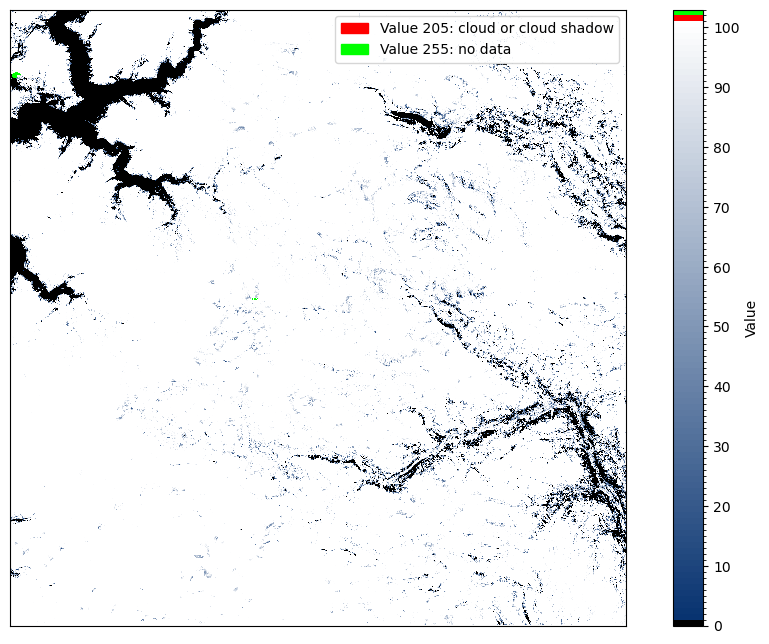

In [17]:
# Create a custom color map
custom_cmap = ListedColormap(productData['GF_cmp'][:101] + [(1, 0, 0), (0, 1, 0)])

# Create a custom normalization to handle the specific values
bounds = list(range(101)) + [205, 255, 256]
norm = plt.cm.colors.BoundaryNorm(bounds, custom_cmap.N)

# Plot the image with the custom color map and normalization
plt.imshow(productData['GF'], cmap=custom_cmap, norm=norm, interpolation='nearest')
plt.clim(0, 255)
plt.colorbar(ticks=list(range(0, 101, 10)), label='Value')
plt.xticks([])
plt.yticks([])

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=(1, 0, 0), label='Value 205: cloud or cloud shadow'),
    mpatches.Patch(color=(0, 1, 0), label='Value 255: no data')
]

# Add the custom legend to the plot
plt.legend(handles=legend_patches, loc='upper right')

This layer shows gap-filled FSC data, which includes data from up to 7 days before. The XML metadata in the product contains information from all the input products, allowing us to list the input products, their sensing times, and calculate the age of the data relative to the GFSC product.

In [21]:
print('TYPE\tSENSING TIME\t\tAGE')
for input_meta in productData['meta']['gmd:MD_Metadata']['gmd:series']['gmd:DS_OtherAggregate']['gmd:seriesMetadata']:
    input_title = input_meta['gmd:MD_Metadata']['gmd:fileIdentifier']['gco:CharacterString']
    input_type = input_title.split('_')[0]
    input_startDate = dateutil.parser.isoparse(input_meta['gmd:MD_Metadata']['gmd:identificationInfo']['gmd:MD_DataIdentification']['gmd:extent']['gmd:EX_Extent']['gmd:temporalElement']['gmd:EX_TemporalExtent']['gmd:extent']['gml:TimePeriod']['gml:beginPosition'])
    input_startDate = input_startDate.replace(microsecond=0)
    input_age = product['day'] + datetime.timedelta(days=1) - input_startDate
    print(input_type + '\t' + input_startDate.strftime('%Y-%m-%d %H:%M:%S') + '\t' + str(input_age))

TYPE	SENSING TIME		AGE
SWS	2022-03-07 05:39:22	6 days, 18:20:38
FSC	2022-03-07 11:14:02	6 days, 12:45:58
SWS	2022-03-07 16:54:29	6 days, 7:05:31
FSC	2022-03-09 11:04:01	4 days, 12:55:59
SWS	2022-03-10 06:04:15	3 days, 17:55:45
SWS	2022-03-10 17:19:17	3 days, 6:40:43
FSC	2022-03-11 10:54:10	2 days, 13:05:50
WDS	2022-03-12 05:47:32	1 day, 18:12:28
SWS	2022-03-12 05:47:32	1 day, 18:12:28
FSC	2022-03-12 11:13:56	1 day, 12:46:04
WDS	2022-03-12 17:02:39	1 day, 6:57:21
SWS	2022-03-12 17:02:39	1 day, 6:57:21


Although the XML metadata provides temporal information as a list, the AT layer contains temporal information for each pixel. The sensing time of each pixel is encoded as "Unix time" (seconds since January 1, 1970) in the AT layer. We can create a raster of "age" to show the age of the data in days (decimal) from the end of the product day (e.g., the age for a sensing at noon on the same day will be 12 hours).

In [22]:
product_midnight_timestamp = datetime.datetime.timestamp(product['day'] + datetime.timedelta(days=1))
productData['age'] = (product_midnight_timestamp - productData['AT'])/(60*60*24.)

When "No data" is present, the AT layer has a value of "0". To handle this, we can use "NaN" in the new age raster instead.

In [23]:
np.place(productData['age'],productData['AT'] == 0,np.nan)

Finally, we will draw the new "age" raster using matplotlib:

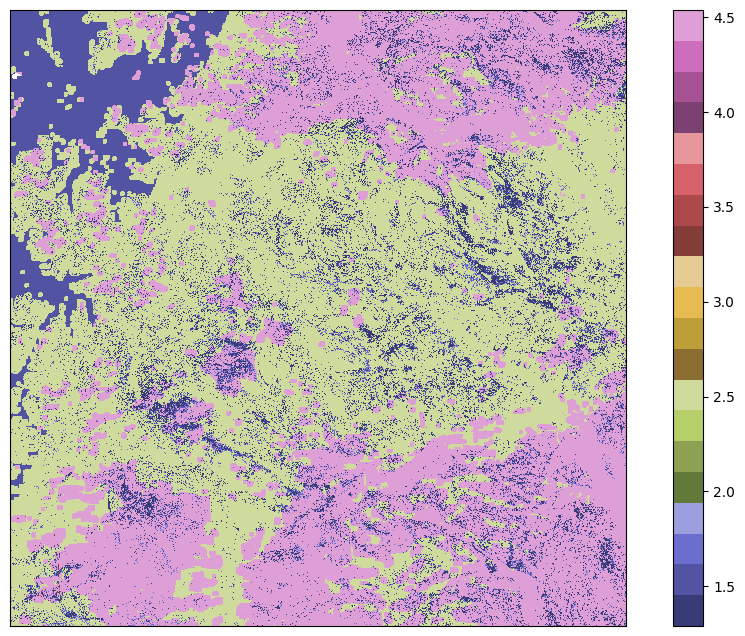

In [24]:
plt.imshow(productData['age'],  cmap = 'tab20b', interpolation = 'nearest');
plt.colorbar();
plt.xticks([]);
plt.yticks([]);

### Manipulating AT Layer to Filter Out Data According to Age of the Pixels

Using the age raster, we can filter out pixels that are "too old" for our analysis. We will create a new GF raster that includes only the pixels with an "age" of no more than 4 days (i.e., data that is at most 3 days old).
<table>
<tr>
<td>
Note: An "invalid value encountered" warning may appear due to np.nan values in the age raster, but these pixels will be excluded from the results and won't affect the outcome.
</td>
</tr>
</table>

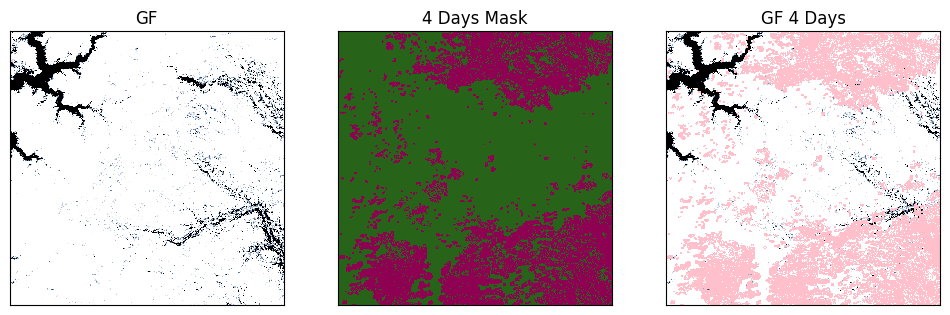

In [26]:
gf_4days = deepcopy(productData['GF'])
np.place(gf_4days, productData['age'] > 4, 255)

plt.subplot(1, 3, 1)
plt.title("GF")
plt.imshow(
    productData['GF'], cmap = ListedColormap(productData['GF_cmp']), interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);
# change the color to a different one
plt.subplot(1, 3, 2)
plt.title("4 Days Mask")
plt.imshow(
    productData['age'] <= 4, cmap = 'PiYG', interpolation = 'nearest'
);
plt.xticks([]);
plt.yticks([]);

plt.subplot(1, 3, 3)
plt.title("GF 4 Days")
plt.imshow(
    gf_4days, cmap = ListedColormap(productData['GF_cmp']), interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);

### Manipulating QCFLAGS Layer to Filter Out Data According to Sensor Type of the Pixels

The QCFLAGS layer is encoded bitwise, containing information for seven different cases in a combined format. Therefore, reading integer values directly from the raster will not be meaningful.

Next, we will draw the QCFLAGS raster using matplotlib:

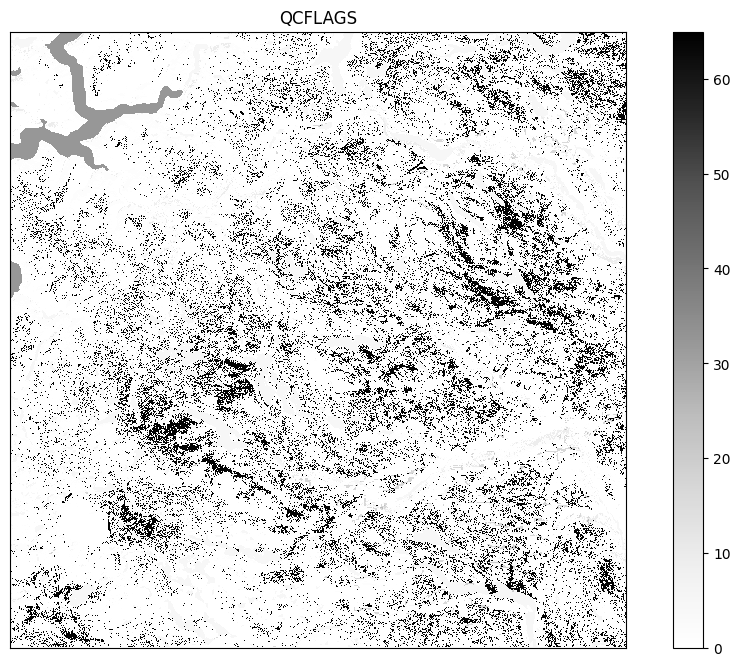

In [27]:
plt.title("QCFLAGS")
plt.imshow(
    productData['QCFLAGS'], cmap = 'Greys', interpolation = 'nearest'
);
plt.xticks([]);
plt.yticks([]);
plt.colorbar();

We need to read the raster bit by bit and interpret the information according to the guidelines in  <a href="https://land.copernicus.eu/user-corner/technical-library/hrsi-snow-pum">the product user manual:</a>

➔ bit 0: sun elevation angle too
low for an accurate
topographic correction (from
MAJA) (active=1) (only valid if
bit 6 is 0)

➔ bit 1: solar elevation angle
tangent to slope (from MAJA)
(active=1) (only valid if bit 6
is 0)

➔ bit 2: water (from EU-Hydro)
(active=1)

➔ bit 3: TCD too high for
accurate forest correction
(TCD>90%) (active=1) (only
valid if bit 6 is 0)

➔ bit 4: snow detected under
thin clouds (active=1) (only
valid if bit 6 is 0)

➔ bit 5: TCD not defined or not
available (active=1) (only
valid if bit 6 is 0)

➔ bit 6: sensor type of the
satellite data (optical=0,
radar=1)

Create a function that uses bit operations to read a single bit as a boolean raster.

In [28]:
def getBit(data,bit):
    # shift the bits to the right until the bit in question is in first digit
    mask = np.right_shift(data,bit)
    # apply "AND 00000001" operation to get the value as 0 or 1.
    mask = np.bitwise_and(mask,1)
    return mask.astype(bool)

# Google "nth bit of a number" for the theory

Read all the bits and visualize them using matplotlib.

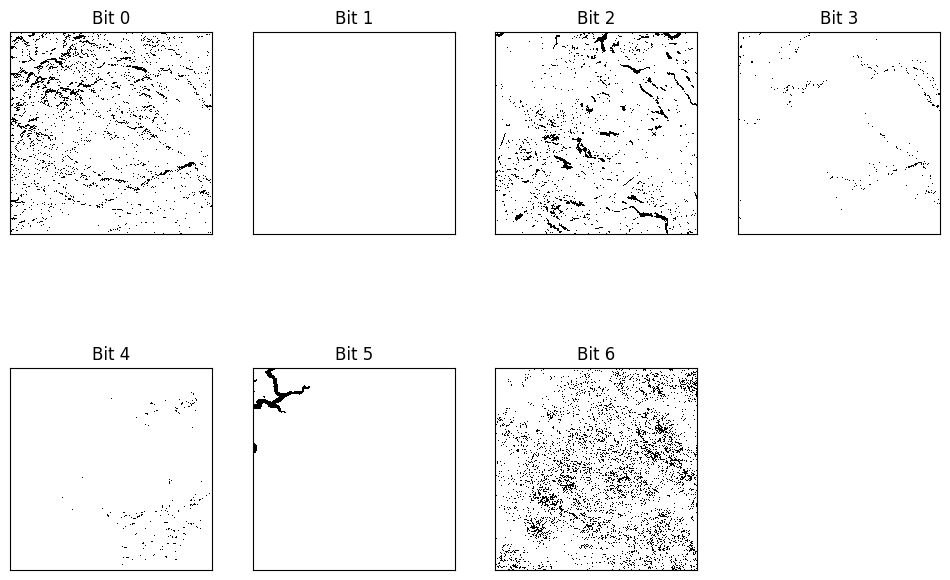

In [29]:
for bit in range(7):
    plt.subplot(2, 4, bit+1)
    plt.title("Bit " + str(bit))
    plt.imshow(
        getBit(productData['QCFLAGS'],bit), cmap = 'binary', interpolation = 'nearest'
    );
    plt.xticks([]);
    plt.yticks([]);

Another example of how to read the QCFLAGS raster can be found in <a href="https://land.copernicus.eu/en/events/pan-european-high-resolution-snow-and-ice-monitoring-product-webinar-2"> "Webinar #2 (13 Oct. 2022): High Resolution Snow and Ice Monitoring"</a> on CLMS website.

Now, we can use the same function to filter or utilize the GF layer based on different information from QCFLAGS. First, we can separate the GF raster by sensor type: if Bit 6 is 1, the pixel is from radar (S1); if Bit 6 is 0, the sensor is optical (S2). We can create rasters and replace the filtered values with the "no data" value (255):

In [30]:
gf_optical = deepcopy(productData['GF'])
gf_radar = deepcopy(productData['GF'])
np.place(gf_radar, ~getBit(productData['QCFLAGS'],6), 255)
np.place(gf_optical, getBit(productData['QCFLAGS'],6), 255)

Visualize the separated rasters together using matplotlib.

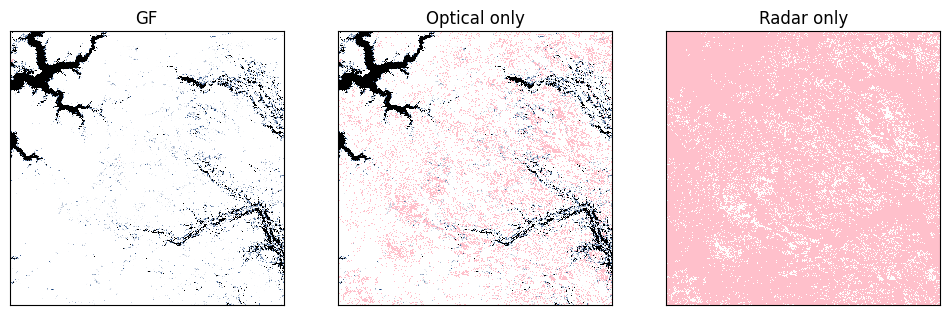

In [31]:
plt.subplot(1, 3, 1)
plt.title("GF")
plt.imshow(
    productData['GF'], cmap = ListedColormap(productData['GF_cmp']),interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);

plt.subplot(1, 3, 2)
plt.title("Optical only")
plt.imshow(
    gf_optical, cmap = ListedColormap(productData['GF_cmp']),interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);

plt.subplot(1, 3, 3)
plt.title("Radar only")
plt.imshow(
    gf_radar, cmap = ListedColormap(productData['GF_cmp']),interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);

### One Last Example

We can combine information from the AT and QCFLAGS layers to filter pixels from the GF layer, for example, selecting only those from the optical sensor and not older than 2 days.

<table>
<tr><td>
Note: An "invalid value encountered" warning may appear due to np.nan values in the age raster, but these pixels will be excluded from the results and won't affect the outcome.
</td></tr>
</table>

In [32]:
gf_day_optical = deepcopy(productData['GF'])
np.place(gf_day_optical, getBit(productData['QCFLAGS'],6), 255)
np.place(gf_day_optical, productData['age'] > 2, 255)

Visualize both the GF layer and the filtered GF layer using matplotlib.

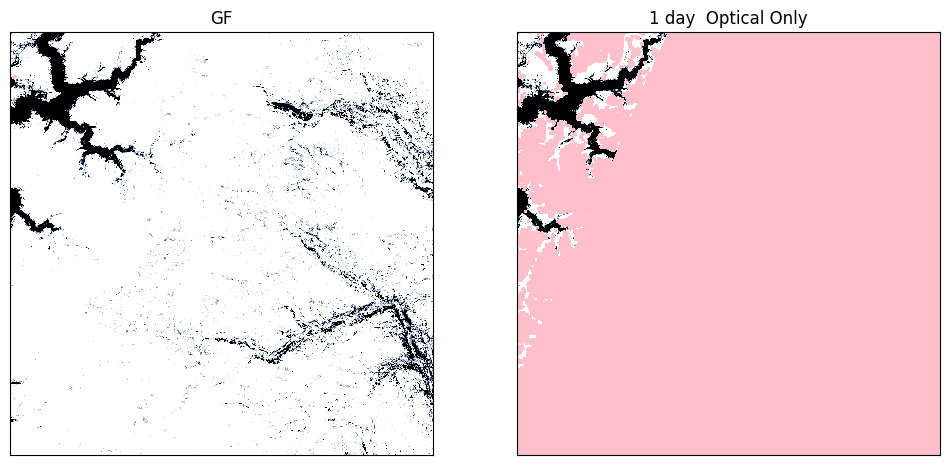

In [33]:
plt.subplot(1, 2, 1)
plt.title("GF")
plt.imshow(
    productData['GF'], cmap = ListedColormap(productData['GF_cmp']), interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);

plt.subplot(1, 2, 2)
plt.title("1 day  Optical Only")
plt.imshow(
    gf_day_optical, cmap = ListedColormap(productData['GF_cmp']), interpolation = 'nearest'
);
plt.clim(0, 255)
plt.xticks([]);
plt.yticks([]);

<hr>

## Cleanup

To ensure a clean workspace and remove all downloaded files and processing artifacts created during this session, run the following code. This will delete any files that were downloaded and processed within this notebook.

In [34]:
paths_to_cleanup = [
    prod_dir,
]

for path in paths_to_cleanup:
    if os.path.isfile(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)

print("Cleanup complete. All downloaded and processed files have been removed.")

Cleanup complete. All downloaded and processed files have been removed.


<hr>

## Data Reference

High Resolution Snow and Ice Monitoring: Daily cumulative Gap-filled Fractional Snow Cover (raster 60m). European Union's Copernicus Land Monitoring Service information, https://www.wekeo.eu/. (Accessed on 28.01.2025)

<hr>

<p><img src='../../media/land/all_partners_wekeo_2.png' align='left' alt='Logo EU Copernicus' height='400px'></img></p>